# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import string

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix, classification_report,roc_curve, roc_auc_score, auc
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.decomposition import LatentDirichletAllocation as LDA, NMF

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout,Flatten, Embedding, LSTM, GRU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

import keras_tuner as kt

import warnings
warnings.filterwarnings('ignore')

tfidf = TfidfVectorizer(ngram_range=(2,2), max_features=1000)
lb = LabelBinarizer()
cv=CountVectorizer()




# Helper functions/classes

In [2]:
class WordCloudGeneration:
    def preprocessing(self, data):
        data = data.split(".")
        # convert all words to lowercase
        data = [item.lower() for item in data]
        # load the stop_words of english
        stop_words = set(stopwords.words('english'))
        # concatenate all the data with spaces.
        paragraph = ' '.join(data)
        # tokenize the paragraph using the inbuilt tokenizer
        word_tokens = word_tokenize(paragraph) 
        # filter words present in stopwords list 
        preprocessed_data = ' '.join([word for word in word_tokens if not word in stop_words])
        return preprocessed_data

    def create_word_cloud(self, final_data,title=""):
        final_data=self.preprocessing(final_data)

        wordcloud = WordCloud(width=1600, height=800, max_font_size=200, background_color="white").generate(final_data)
        plt.figure(figsize=(12,10))
        plt.imshow(wordcloud)
        plt.axis("off")
        plt.title(title,fontsize=40)
        plt.show()

        
wordcloud_generator = WordCloudGeneration()

In [3]:
def show_metrics(true_vals,pred_vals):
    print(pd.DataFrame(confusion_matrix(true_vals,pred_vals),columns=["negative","neutral","positive"],index=["negative","neutral","positive"]))
    print("\n")
    print(classification_report(true_vals,pred_vals))
    show_roc(true_vals,pred_vals)

def show_roc(y_val,y_pred):
    lb.fit(y_val)
    y_val1 = lb.transform(y_val)
    y_pred1 = lb.transform(y_pred)
    print(f"WEIGHTED_ROC_AUC_SCORE: {roc_auc_score(y_val1, y_pred1, average='weighted'):.3f}")
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(3):
        fpr[i], tpr[i], _ = roc_curve(y_val1[:, i], y_pred1[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    lw=2
    for i in range(3):
        plt.plot(fpr[i], tpr[i], lw=lw,
                label='ROC curve of class Model (area = {1:0.2f})'
                ''.format(i, roc_auc[i]))

    plt.plot([0, 1], [0, 1], 'k--', lw=lw)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic of current Model')
    plt.legend(loc="lower right")
    plt.show()
    
def to_labels(series):
  le=LabelEncoder()
  return le.fit_transform(series)


def get_tfidf(reviews):
    reviews_tfidf_Vect =tfidf.fit(reviews)
    feature_names = reviews_tfidf_Vect.get_feature_names()
    reviews_tfidf_dtm =tfidf.transform(reviews)
    reviews_tfidf_dtm_df =pd.DataFrame(reviews_tfidf_dtm.toarray(),columns=feature_names)

    return reviews_tfidf_dtm_df

def clean_data(reviews):
    #deal with casing
    reviews = reviews.apply(lambda x:x.lower())

    #used regex to remove URLS
    URLpattern = "(https?:\/\/)(\s)*(www\.)?(\s)*((\w|\s)+\.)*([\w\-\s]+\/)*([\w\-]+)((\?)?[\w\s]*=\s*[\w\%&]*)*"
    reviews = reviews.apply(lambda x:re.sub(URLpattern,"",x))

    #remove hash symbols
    reviews = reviews.apply(lambda x:re.sub("#","",x))

    #remove extra '....'
    reviews = reviews.apply(lambda x:re.sub("\.+","",x))

    #remove anomolies
    anomolies =[
        "äî",
        "äú",
        "äù",
        "äô",
        "äã",
        "äò"
        
    ]
    for anomoly in anomolies:
        reviews = reviews.apply(lambda x:re.sub(anomoly," ",x))
        
    #tokenize
    reviews = reviews.apply(word_tokenize)

    reviews = reviews.apply(lambda x:[word for word in x if word not in stop_words and len(word)>1 and word not in string.punctuation])


    #rejoin tokens into text

    reviews = reviews.apply(lambda x:" ".join(x))
    return reviews


# EDA

In [4]:
train_df = pd.read_csv("..\Datasets\Ecommerce\\train_data.csv")
test_df = pd.read_csv("..\Datasets\Ecommerce\\test_data.csv")
test_val_df = pd.read_csv("..\Datasets\Ecommerce\\test_data_hidden.csv")

In [5]:
train_df.duplicated().sum(), test_df.duplicated().sum(), test_val_df.duplicated().sum()

(58, 3, 3)

**Found existing duplicate data**

In [6]:
train_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,4000,4000,4000,4000,4000,4000,3990,4000
unique,23,1,23,4,638,3598,2606,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,I bought this kindle for my 11yr old granddaug...,Great tablet,Positive
freq,676,4000,628,2600,99,4,100,3749


In [7]:
train_df.dtypes

name                 object
brand                object
categories           object
primaryCategories    object
reviews.date         object
reviews.text         object
reviews.title        object
sentiment            object
dtype: object

In [8]:
test_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!


In [9]:
test_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title
count,1000,1000,1000,1000,1000,1000,997
unique,23,1,23,4,366,979,796
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,It was all that my grandson wanted and didn't ...,Great tablet
freq,169,1000,169,676,26,2,22


In [10]:
test_val_df.head()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
0,"Fire Tablet, 7 Display, Wi-Fi, 16 GB - Include...",Amazon,"Fire Tablets,Computers/Tablets & Networking,Ta...",Electronics,2016-05-23T00:00:00.000Z,Amazon kindle fire has a lot of free app and c...,very handy device,Positive
1,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2018-01-02T00:00:00.000Z,The Echo Show is a great addition to the Amazo...,Another winner from Amazon,Positive
2,"All-New Fire HD 8 Tablet, 8"" HD Display, Wi-Fi...",Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-02T00:00:00.000Z,Great value from Best Buy. Bought at Christmas...,simple to use and reliable so far,Positive
3,"Brand New Amazon Kindle Fire 16gb 7"" Ips Displ...",Amazon,"Computers/Tablets & Networking,Tablets & eBook...",Electronics,2017-03-25T00:00:00.000Z,"I use mine for email, Facebook ,games and to g...",Love it!!!,Positive
4,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Computers,Amazon Echo,Virtual Assistant Speake...","Electronics,Hardware",2017-11-15T00:00:00.000Z,This is a fantastic item & the person I bought...,Fantastic!,Positive


In [11]:
test_val_df.describe()

,name,brand,categories,primaryCategories,reviews.date,reviews.text,reviews.title,sentiment
count,1000,1000,1000,1000,1000,1000,997,1000
unique,23,1,23,4,366,979,796,3
top,Amazon Echo Show Alexa-enabled Bluetooth Speak...,Amazon,"Electronics,iPad & Tablets,All Tablets,Fire Ta...",Electronics,2017-01-23T00:00:00.000Z,It was all that my grandson wanted and didn't ...,Great tablet,Positive
freq,169,1000,169,676,26,2,22,937


In [12]:
train_df.isnull().sum()

name                  0
brand                 0
categories            0
primaryCategories     0
reviews.date          0
reviews.text          0
reviews.title        10
sentiment             0
dtype: int64

In [13]:
test_df.isnull().sum()

name                 0
brand                0
categories           0
primaryCategories    0
reviews.date         0
reviews.text         0
reviews.title        3
dtype: int64

**Null values found in reviews.title   -  Fill  with empty string**

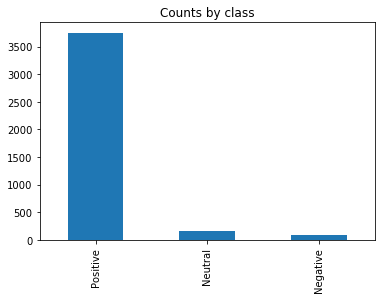

In [14]:
train_df["sentiment"].value_counts().plot(kind="bar", title="Counts by class")

**Class Imbalance Problem - Will try oversampling and classweights**

In [15]:
Positive_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Positive"]["reviews.text"]:
    Positive_Review_Text += " " +review.lower()

Negative_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Negative"]["reviews.text"]:
    Negative_Review_Text += " " +review.lower()

Neutral_Review_Text = ""
for review in  train_df[train_df["sentiment"]=="Neutral"]["reviews.text"]:
    Neutral_Review_Text += " " +review.lower()


# Wordclouds

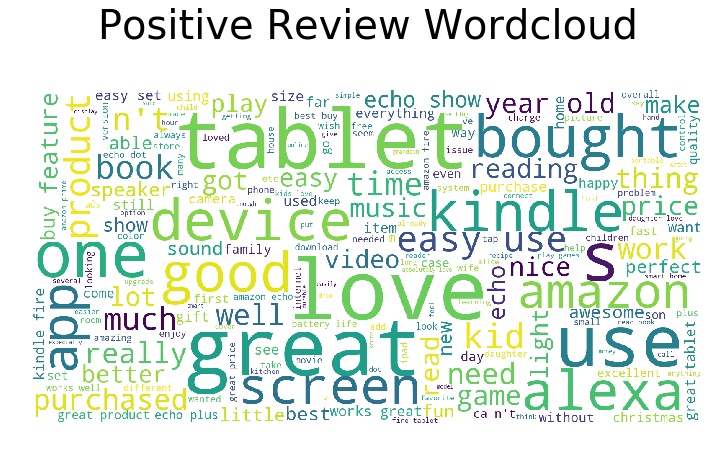

In [16]:

wordcloud_generator.create_word_cloud(Positive_Review_Text,"Positive Review Wordcloud\n")

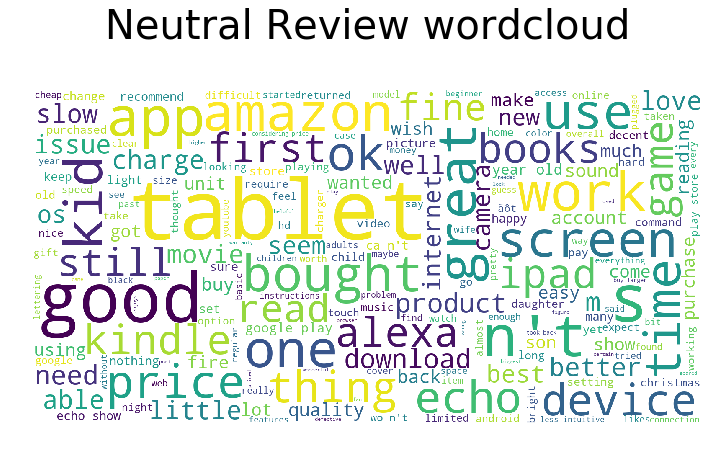

In [17]:
wordcloud_generator.create_word_cloud(Neutral_Review_Text,"Neutral Review wordcloud\n")

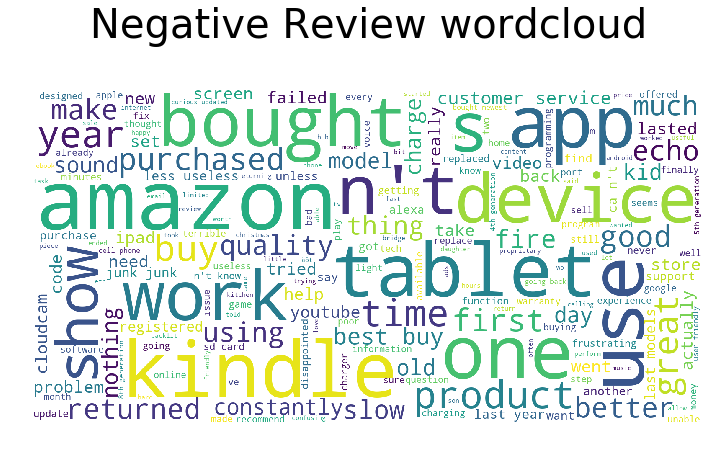

In [18]:
wordcloud_generator.create_word_cloud(Negative_Review_Text,"Negative Review wordcloud\n")

# Observations 

Duplicates found in all datasets
**Drop Duplicates**

**Will drop all columns except text and title**

Sentiment is categorical:
**LabelEncoder**

reviews.text and reviews.title are text:
**TFIDF**
**Sentiment Analysis**

null values in reviews.title:
**fill null value with " "**

class imbalance issue:
**oversampling**
**class weights**



# Tasks based on observations

Remove Duplicates

In [19]:
train_df=train_df[train_df.duplicated()==False]
test_df=test_df[test_df.duplicated()==False]
test_val_df=test_val_df[test_val_df.duplicated()==False]

train_df.reset_index(inplace=True)
test_val_df.reset_index(inplace=True)
test_df.reset_index(inplace=True)

fill null values

In [20]:
# train_df['reviews.title'].fillna(value='',inplace=True)
# test_val_df['reviews.title'].fillna(value=' ',inplace=True)
# test_df['reviews.title'].fillna(value=' ',inplace=True)

Keep only desired columns

In [21]:
train_df=train_df[["reviews.text","sentiment"]]
test_df=test_df["reviews.text"]
test_val_df=test_val_df[["reviews.text","sentiment"]]

# Processing Data

Encode categories

In [22]:


train_df["sentiment"]=to_labels(train_df["sentiment"])
test_val_df["sentiment"]=to_labels(test_val_df["sentiment"])


train_df.shape,test_df.shape,test_val_df.shape

((3942, 2), (997,), (997, 2))

In [23]:
train_df.head()

,reviews.text,sentiment
0,Purchased on Black FridayPros - Great Price (e...,2
1,I purchased two Amazon in Echo Plus and two do...,2
2,Just an average Alexa option. Does show a few ...,1
3,"very good product. Exactly what I wanted, and ...",2
4,This is the 3rd one I've purchased. I've bough...,2


In [24]:
review_text_train = train_df["reviews.text"]
review_text_test = test_val_df["reviews.text"]

In [25]:
stop_words = stopwords.words("english")

In [26]:
train_df["reviews.text"] = clean_data(review_text_train)
# train_df["reviews.title"] = clean_data(review_title_train)
test_df["reviews.text"] = clean_data(review_text_test)
# test_df["reviews.title"] = clean_data(review_title_test)
test_val_df["reviews.text"] = clean_data(review_text_test)
# test_val_df["reviews.title"] = clean_data(review_title_test)

In [27]:
reviewsCV_fit = cv.fit(train_df["reviews.text"])
reviewsCV = reviewsCV_fit.transform(train_df["reviews.text"])

Vectorize text with Tfidf

In [28]:
# get_sentiment_scores(train_df)
# get_sentiment_scores(test_df)
# get_sentiment_scores(test_val_df)

train_text_tfidf_df = get_tfidf(review_text_train).to_numpy(dtype="float16")
# train_title_tfidf_df = get_tfidf(review_title_train).to_numpy(dtype="float16")
test_text_tfidf_df = get_tfidf(review_text_test).to_numpy(dtype="float16")
# test_title_tfidf_df = get_tfidf(review_title_test).to_numpy(dtype="float16")

y_train1 = train_df["sentiment"].to_numpy(dtype="float16")
y_test = test_val_df["sentiment"].to_numpy(dtype="float16")




# Multinomial Naive Bayes Classification 


In [508]:
model = MultinomialNB()

## On Unaltered Data

In [509]:
X_train,X_test,y_train,y_test = train_test_split(train_text_tfidf_df,y_train1, test_size=.3,random_state=42)

In [510]:
model.fit(X_train,y_train)

MultinomialNB()

          negative  neutral  positive
negative         0        0        22
neutral          0        0        42
positive         0        0      1119


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        22
         1.0       0.00      0.00      0.00        42
         2.0       0.95      1.00      0.97      1119

    accuracy                           0.95      1183
   macro avg       0.32      0.33      0.32      1183
weighted avg       0.89      0.95      0.92      1183

WEIGHTED_ROC_AUC_SCORE: 0.500


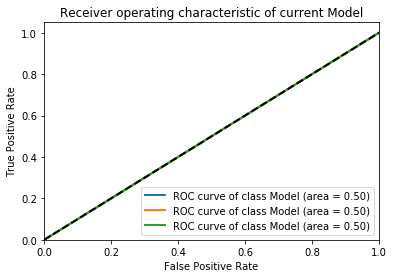

In [511]:
preds=model.predict(X_test)
show_metrics(y_test,preds)

**On unaltered Data all reviews are predicted as positive due to significant class imbalance**

## On oversampled Data

In [512]:
sm=SMOTE()
X_over,y_over=sm.fit_resample(train_text_tfidf_df,y_train1)
X_train,X_test,y_train,y_test = train_test_split(X_over,y_over, test_size=.3,random_state=42)

          negative  neutral  positive
negative      1068       30         0
neutral        248      850         6
positive       239      124       760


              precision    recall  f1-score   support

         0.0       0.69      0.97      0.81      1098
         1.0       0.85      0.77      0.81      1104
         2.0       0.99      0.68      0.80      1123

    accuracy                           0.81      3325
   macro avg       0.84      0.81      0.81      3325
weighted avg       0.84      0.81      0.81      3325

WEIGHTED_ROC_AUC_SCORE: 0.855


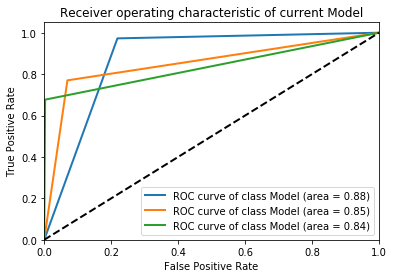

In [513]:
model.fit(X_train,y_train)
preds=model.predict(X_test)
show_metrics(y_test,preds)

**We see significant predictive improvement once we oversample the dataset with SMOTE**

### Defining Models to test

In [464]:
models=[
        RandomForestClassifier(class_weight='balanced'),
        XGBClassifier(use_label_encoder=False, n_estimators=5,n_jobs=-1)
        ]


## Testing Models

RandomForestClassifier(class_weight='balanced') 
 ************************************************** 

          negative  neutral  positive
negative      1089        7         2
neutral        212      884         8
positive       243      107       773


              precision    recall  f1-score   support

         0.0       0.71      0.99      0.82      1098
         1.0       0.89      0.80      0.84      1104
         2.0       0.99      0.69      0.81      1123

    accuracy                           0.83      3325
   macro avg       0.86      0.83      0.83      3325
weighted avg       0.86      0.83      0.83      3325

WEIGHTED_ROC_AUC_SCORE: 0.870


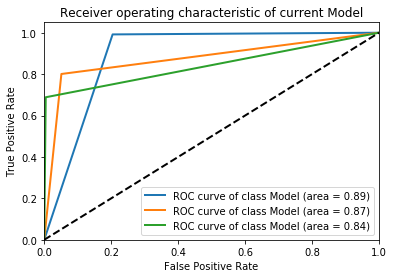

XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None,
              enable_categorical=False, gamma=None, gpu_id=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=5, n_jobs=-1, num_parallel_tree=None, predictor=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              use_label_encoder=False, validate_parameters=None,
              verbosity=None) 
 ************************************************** 

[00:25:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like 

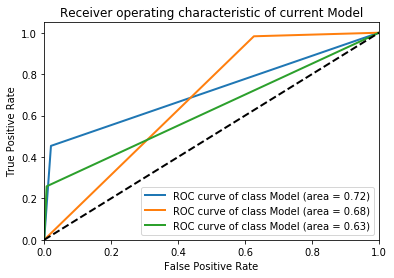

In [465]:
for model in models:
    print(model,"\n","*"*50,"\n")

    model.fit(X_train,y_train)
    preds = model.predict(X_test)
    show_metrics(y_test,preds)

**We see similar Predictive Improvement with Random Forest and XGBoost classifiers with oversampled Data**

# Simple Neural Network

In [466]:

es=EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=2,
    verbose=2,
    mode='auto',
    baseline=None,
    restore_best_weights=True,)
y_train2 = label_binarize(y_train, classes=[0, 1, 2])    
y_test2 = label_binarize(y_test, classes=[0, 1, 2])    


In [467]:
NN= Sequential()
NN.add(Flatten())
NN.add(Dense(64, activation="relu"))
NN.add(Dropout(.4))
NN.add(Dense(128,activation="relu"))
NN.add(Dropout(.4))
NN.add(Dense(256,activation="relu"))

NN.add(Dropout(.4))
NN.add(Dense(3,activation="softmax"))
NN.compile(optimizer="adam",loss="categorical_crossentropy",metrics=["acc"])

In [468]:

NN.fit(X_train,y_train2,epochs=100, validation_data=[X_test,y_test2],callbacks=[es])

Epoch 1/100
243/243 [==============================] - 4s 8ms/step - loss: 0.7460 - acc: 0.6689 - val_loss: 0.3748 - val_acc: 0.8592
Epoch 2/100
243/243 [==============================] - 2s 7ms/step - loss: 0.3581 - acc: 0.8533 - val_loss: 0.3029 - val_acc: 0.8761
Epoch 3/100
243/243 [==============================] - 2s 7ms/step - loss: 0.3176 - acc: 0.8645 - val_loss: 0.3200 - val_acc: 0.8674
Epoch 4/100
243/243 [==============================] - 2s 7ms/step - loss: 0.2998 - acc: 0.8719 - val_loss: 0.2786 - val_acc: 0.8809
Epoch 5/100
243/243 [==============================] - 2s 7ms/step - loss: 0.2936 - acc: 0.8707 - val_loss: 0.2842 - val_acc: 0.8791
Epoch 6/100
243/243 [==============================] - 2s 7ms/step - loss: 0.2874 - acc: 0.8766 - val_loss: 0.2812 - val_acc: 0.8863
Epoch 00006: early stopping


In [469]:
preds_array = NN.predict(X_test)
pred_list = []
for i,pred in enumerate(preds_array):
    pred_list.append(pred.argmax())

          negative  neutral  positive
negative      1098        0         0
neutral        223      881         0
positive       146       27       950


              precision    recall  f1-score   support

         0.0       0.75      1.00      0.86      1098
         1.0       0.97      0.80      0.88      1104
         2.0       1.00      0.85      0.92      1123

    accuracy                           0.88      3325
   macro avg       0.91      0.88      0.88      3325
weighted avg       0.91      0.88      0.88      3325

WEIGHTED_ROC_AUC_SCORE: 0.911


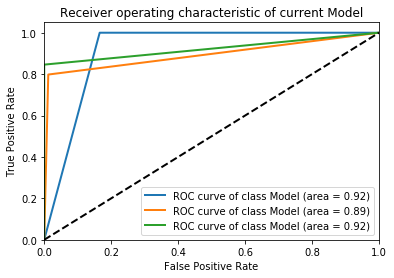

In [470]:
show_metrics(y_test,pred_list)

**Utilizing a simple Neural network, we are able to further improve the predictive capabilities of our model**

# Using LSTM to predict classes

In [471]:

y_train2 = label_binarize(y_train, classes=[0, 1, 2])
y_test2 = label_binarize(y_test, classes=[0,1,2])
epochs = 10
emb_dim = 64
batch_size = 128
units=4
do=0.
rdo=0.
num_layers=1



In [475]:
earlystopping=EarlyStopping(
  monitor="val_loss",
  patience=2,
  mode="auto",
  restore_best_weights=True
)

In [476]:
model = Sequential()
model.add(Embedding(X_train.shape[0], emb_dim, input_length=X_train.shape[1]))
model.add(LSTM(units, dropout=do, recurrent_dropout=rdo))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc","AUC"])

In [477]:
model.fit(
  X_train, 
  y_train2, 
  epochs=epochs,
  batch_size=batch_size,
    callbacks=[earlystopping],
  validation_data=[X_test,y_test2],
  )


Epoch 1/10
61/61 [==============================] - 43s 651ms/step - loss: 1.0989 - acc: 0.3385 - auc: 0.5014 - val_loss: 1.0991 - val_acc: 0.3302 - val_auc: 0.4992
Epoch 2/10
61/61 [==============================] - 39s 635ms/step - loss: 1.0990 - acc: 0.3352 - auc: 0.4957 - val_loss: 1.0986 - val_acc: 0.3377 - val_auc: 0.5013
Epoch 3/10
61/61 [==============================] - 39s 644ms/step - loss: 1.0988 - acc: 0.3311 - auc: 0.4989 - val_loss: 1.0986 - val_acc: 0.3377 - val_auc: 0.5034
Epoch 4/10
61/61 [==============================] - 39s 647ms/step - loss: 1.0989 - acc: 0.3265 - auc: 0.4969 - val_loss: 1.0987 - val_acc: 0.3320 - val_auc: 0.4974
Epoch 5/10
61/61 [==============================] - 40s 649ms/step - loss: 1.0988 - acc: 0.3322 - auc: 0.4939 - val_loss: 1.0988 - val_acc: 0.3326 - val_auc: 0.4982


          negative  neutral  positive
negative         0        0      1098
neutral          0        0      1104
positive         0        0      1123


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00      1098
         1.0       0.00      0.00      0.00      1104
         2.0       0.34      1.00      0.50      1123

    accuracy                           0.34      3325
   macro avg       0.11      0.33      0.17      3325
weighted avg       0.11      0.34      0.17      3325

WEIGHTED_ROC_AUC_SCORE: 0.500


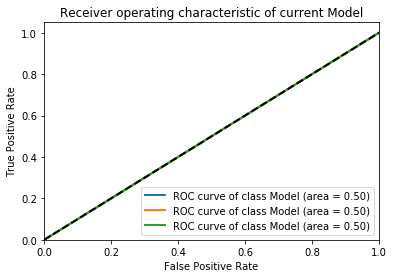

In [478]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)

**Initial attempt to make a predictive model with LSTM cells yielded a model that predicts all reviews to be positive**

# Using GRU to predict classes

In [479]:
model = Sequential()
model.add(Embedding(X_train.shape[0], emb_dim, input_length=X_train.shape[1]))
model.add(GRU(layers, dropout=do, recurrent_dropout=rdo))
model.add(Dense(3, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=["acc","AUC"])


Epoch 1/10
61/61 [==============================] - 43s 638ms/step - loss: 1.0988 - acc: 0.3287 - auc: 0.5040 - val_loss: 1.1006 - val_acc: 0.3302 - val_auc: 0.4964
Epoch 2/10
61/61 [==============================] - 38s 624ms/step - loss: 1.0995 - acc: 0.3307 - auc: 0.4963 - val_loss: 1.0990 - val_acc: 0.3302 - val_auc: 0.4980
Epoch 3/10
61/61 [==============================] - 39s 633ms/step - loss: 1.0990 - acc: 0.3330 - auc: 0.4948 - val_loss: 1.0987 - val_acc: 0.3308 - val_auc: 0.4997
Epoch 4/10
61/61 [==============================] - 39s 636ms/step - loss: 1.0988 - acc: 0.3401 - auc: 0.4999 - val_loss: 1.0987 - val_acc: 0.3326 - val_auc: 0.5016
Epoch 5/10
61/61 [==============================] - 34s 562ms/step - loss: 1.0990 - acc: 0.3234 - auc: 0.4939 - val_loss: 1.0987 - val_acc: 0.3314 - val_auc: 0.4977
Epoch 6/10
61/61 [==============================] - 34s 563ms/step - loss: 1.0988 - acc: 0.3348 - auc: 0.4997 - val_loss: 1.0993 - val_acc: 0.3308 - val_auc: 0.4971
          

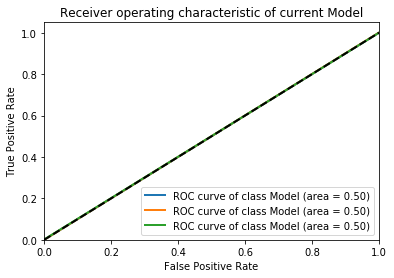

In [480]:
model.fit(
  X_train, 
  y_train2, 
  epochs=epochs, 
  batch_size=batch_size,
  validation_data=[X_test,y_test2],
  callbacks=[earlystopping])
preds = model.predict(X_test, batch_size=100)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)


**Initial attempt to make a predictive model with GRU cells yielded a model that predicts most reviews to be Neutral**

# Finetuning LSTM/GRU with keras-tuner randomsearch

In [491]:
def buildLSTM(hp):
    model = Sequential()
    units = hp.Choice("units", [2,4])
    emb_dim = hp.Choice("embedding", [16,32])
    do=hp.Choice("DropOff", [0.,0.3])
    rdo=hp.Choice("RecurrentDropOff", [0.,0.3])
    addtl_layers=hp.Choice("additionalLayers", [0,1])
    
    model.add(Embedding(X_train.shape[0], emb_dim, input_length=X_train.shape[1]))
    
    for i in range(addtl_layers):
        model.add(LSTM(units, dropout=do, recurrent_dropout=rdo, return_sequences=True))
    model.add(LSTM(units, dropout=do, recurrent_dropout=rdo))
    model.add(Dense(3, activation='softmax'))
    model.optimizer = hp.Choice("optimizer",["adam","rmsprop"])
    model.compile(loss="categorical_crossentropy", metrics=["acc","AUC"])
    return model

In [499]:

LSTMtuner = kt.RandomSearch(
    buildLSTM,
    objective='val_loss',
    max_trials=10,
    project_name="LSTMTuner"
)

LSTMtuner.search(X_train,y_train2,epochs=5,batch_size=batch_size,validation_data=(X_test,y_test2))

Trial 10 Complete [00h 04m 59s]
val_loss: 1.0985767841339111

Best val_loss So Far: 1.0985767841339111
Total elapsed time: 00h 53m 28s
INFO:tensorflow:Oracle triggered exit


Epoch 1/10
61/61 [==============================] - 60s 917ms/step - loss: 1.0989 - acc: 0.3383 - auc: 0.4964 - val_loss: 1.0989 - val_acc: 0.3320 - val_auc: 0.4992
Epoch 2/10
61/61 [==============================] - 56s 914ms/step - loss: 1.0990 - acc: 0.3303 - auc: 0.4955 - val_loss: 1.0986 - val_acc: 0.3320 - val_auc: 0.5011
Epoch 3/10
61/61 [==============================] - 55s 902ms/step - loss: 1.0988 - acc: 0.3344 - auc: 0.4968 - val_loss: 1.0986 - val_acc: 0.3317 - val_auc: 0.5004
Epoch 4/10
61/61 [==============================] - 56s 922ms/step - loss: 1.0987 - acc: 0.3312 - auc: 0.5005 - val_loss: 1.0988 - val_acc: 0.3320 - val_auc: 0.4998
Epoch 5/10
61/61 [==============================] - 54s 891ms/step - loss: 1.0990 - acc: 0.3224 - auc: 0.4910 - val_loss: 1.0986 - val_acc: 0.3317 - val_auc: 0.5004
          negative  neutral  positive
negative      1098        0         0
neutral       1099        5         0
positive      1119        4         0


              precisi

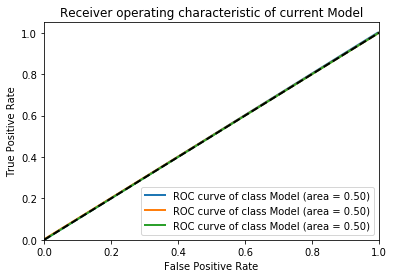

In [500]:
LSTMmodel = LSTMtuner.get_best_models()[0]
LSTMmodel.fit(
  X_train, 
  y_train2, 
  epochs=epochs, 
  batch_size=batch_size,
  validation_data=[X_test,y_test2],
  callbacks=[earlystopping])
preds = LSTMmodel.predict(X_test, batch_size=100)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)


In [504]:
LSTMmodel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1000, 32)          248224    
                                                                 
 lstm (LSTM)                 (None, 4)                 592       
                                                                 
 dense (Dense)               (None, 3)                 15        
                                                                 
Total params: 248,831
Trainable params: 248,831
Non-trainable params: 0
_________________________________________________________________


**Performance after tuning LSTM model yields no improvement**

In [501]:
def buildGRU(hp):
    model = Sequential()
    units = hp.Choice("units", [2,4])
    emb_dim = hp.Choice("embedding", [16,32])
    do=hp.Choice("DropOff", [0.,0.3])
    rdo=hp.Choice("RecurrentDropOff", [0.,0.3])
    addtl_layers=hp.Choice("additionalLayers", [0,1,2])
    
    model.add(Embedding(X_train.shape[0], emb_dim, input_length=X_train.shape[1]))
    
    for i in range(addtl_layers):
        model.add(GRU(units, dropout=do, recurrent_dropout=rdo, return_sequences=True))
    model.add(GRU(units, dropout=do, recurrent_dropout=rdo))
    model.add(Dense(3, activation='softmax'))
    model.optimizer = hp.Choice("optimizer",["adam","rmsprop"])
    model.compile(loss="categorical_crossentropy", metrics=["acc","AUC"])
    return model

In [502]:
GRUtuner = kt.RandomSearch(
    buildGRU,
    objective='val_loss',
    max_trials=10,
    project_name="GRUTuner"
)
GRUtuner.search(X_train,y_train2,epochs=5, batch_size=batch_size,validation_data=(X_test,y_test2))

Trial 10 Complete [00h 04m 50s]
val_loss: 1.0986560583114624

Best val_loss So Far: 1.0985623598098755
Total elapsed time: 01h 12m 10s
INFO:tensorflow:Oracle triggered exit


Epoch 1/10
61/61 [==============================] - 43s 652ms/step - loss: 1.0990 - acc: 0.3280 - auc: 0.4946 - val_loss: 1.0987 - val_acc: 0.3302 - val_auc: 0.4970
Epoch 2/10
61/61 [==============================] - 39s 648ms/step - loss: 1.0988 - acc: 0.3374 - auc: 0.5010 - val_loss: 1.0986 - val_acc: 0.3380 - val_auc: 0.5024
Epoch 3/10
61/61 [==============================] - 39s 648ms/step - loss: 1.0989 - acc: 0.3316 - auc: 0.4964 - val_loss: 1.0986 - val_acc: 0.3377 - val_auc: 0.5041
Epoch 4/10
61/61 [==============================] - 39s 647ms/step - loss: 1.0990 - acc: 0.3224 - auc: 0.4940 - val_loss: 1.0989 - val_acc: 0.3302 - val_auc: 0.4964
Epoch 5/10
61/61 [==============================] - 40s 658ms/step - loss: 1.0989 - acc: 0.3334 - auc: 0.4939 - val_loss: 1.0987 - val_acc: 0.3317 - val_auc: 0.4971
          negative  neutral  positive
negative         0        0      1098
neutral          0        0      1104
positive         0        0      1123


              precisi

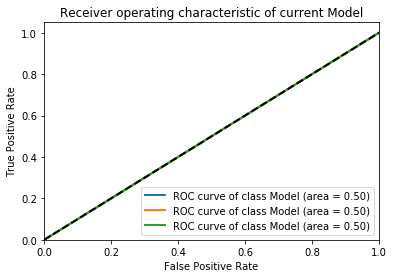

In [503]:
GRUmodel = GRUtuner.get_best_models()[0]
GRUmodel.fit(
  X_train, 
  y_train2, 
  epochs=epochs, 
  batch_size=batch_size,
  validation_data=[X_test,y_test2],
  callbacks=[earlystopping])
preds = GRUmodel.predict(X_test, batch_size=100)
preds = np.argmax(preds, axis=1)
show_metrics(y_test, preds)


## Conclusion - I would recommend the use of either Random Forest or the simple neural network for prodicting the sentiment of these reviews due to thier individual performance metrics.

# Topic Modeling

## Determining number of topics

In [29]:
nodes = []
for i in range(3,8):
    kmeans = KMeans(n_clusters=i,init='k-means++',max_iter=300,n_init=10,random_state=42,n_jobs=-1)
    print(".",end="")
    kmeans.fit(reviewsCV)
    nodes.append(kmeans.inertia_)
    
print("done")


.....done


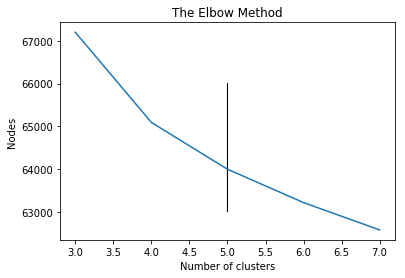

In [30]:
plt.plot(range(3,8),nodes)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Nodes')
plt.arrow(5, 66000, 0, -3000)
plt.show()

## Topic modelling with Latent Dirchlet Allocation

In [38]:
def print_topics(model, count_vectorizer, n_top_words):
    words = count_vectorizer.get_feature_names()
    for topic_idx, topic in enumerate(model.components_):
        print(f"\nTopic #{topic_idx+1}")
        print(" ".join([words[i]
                        for i in topic.argsort()[:-n_top_words - 1:-1]]))
        


In [39]:

# Tweak the two parameters below
number_topics = 5
number_words = 10
# Create and fit the LDA model
lda = LDA(n_components=number_topics, n_jobs=-1)
lda.fit(reviewsCV)
# Print the topics found by the LDA model
print("Topics found via LDA:")
print_topics(lda, reviewsCV_fit, number_words)

Topics found via LDA:

Topic #1
tablet great use easy kids loves bought good love price

Topic #2
kindle love great read easy one screen use light fire

Topic #3
bought much like kindle one amazon better really new get

Topic #4
echo alexa great music show amazon love use sound home

Topic #5
would one product recommend great easy buy use purchased smart


*Topic 1: Kindle for Kids*

*Topic 2: Screen*

*Topic 3: Kindle*

*Topic 4: Alexa for Music*

*Topic 5 : Ease of Use*


## Topic Modelling with Non Negative Matrix Factorization

In [41]:

number_topics = 5
number_words = 10
# Create and fit the NMF model
nmf = NMF(n_components=number_topics)
nmf.fit(reviewsCV)
# Print the topics found by the NMF model
print("Topics found via Non Negative Matrix Factorization:")
print_topics(nmf, reviewsCV_fit, number_words)

Topics found via Non Negative Matrix Factorization:

Topic #1
device amazon screen use apps app home button magazines magazine

Topic #2
kindle would charge oasis read one bought reading cover book

Topic #3
echo show alexa music love amazon sound would screen video

Topic #4
tablet good bought old games year price play kids amazon

Topic #5
great use easy product works love price kids set well


*Topic 1: Screen*

*Topic 2: Kindle for reading*

*Topic 3: Alexa for Music*

*Topic 4: Kindle for Games*

*Topic 5 : Ease of Use*